In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from imblearn.over_sampling import SMOTE


In [46]:


df = pd.read_csv('../data/combined_sleep_dataset.csv')
df


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Patient_ID,AHI_Score,SaO2_Level,Diagnosis_Confirmed,Sleep_disorder
0,1,27,9,6.1,6,42,6,3,11,77,4200,88,47.20,98.11,1,1
1,1,27,9,6.1,6,42,6,3,11,77,4200,90,18.56,91.75,1,3
2,1,27,9,6.1,6,42,6,3,11,77,4200,126,42.71,78.61,1,0
3,1,27,9,6.1,6,42,6,3,11,77,4200,164,27.12,82.61,1,3
4,1,27,9,6.1,6,42,6,3,11,77,4200,192,49.10,76.13,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,0,59,5,8.1,9,75,3,3,23,68,7000,148,4.75,82.91,1,5
2252,0,59,5,8.1,9,75,3,3,23,68,7000,152,46.55,98.58,1,5
2253,0,59,5,8.1,9,75,3,3,23,68,7000,220,14.17,83.15,1,5
2254,0,59,5,8.1,9,75,3,3,23,68,7000,255,33.95,91.90,1,5


---

### predicción de la calidad del sueño, duración del sueño, trastornos del sueño y estrés

---

### Predecir si un paciente está o no diagnosticado

In [47]:
# 1. Preparar las variables
# Definir las características (X) y la variable objetivo (y)
X = df.drop(columns=['Diagnosis_Confirmed', 'Patient_ID'])  # Eliminar la columna objetivo y cualquier identificador único
y = df['Diagnosis_Confirmed']  # La variable objetivo es si el paciente tiene diagnóstico confirmado (1) o no (0)

# 2. Dividir los datos en entrenamiento y prueba
# El parámetro 'stratify' asegura que la distribución de clases en el conjunto de prueba es similar a la de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Preprocesamiento y escalado
# Definir explícitamente las variables categóricas y numéricas
categorical_features = ['Gender', 'Occupation', 'BMI Category', 'Sleep_disorder']
numeric_features = [col for col in X.columns if col not in categorical_features]

# Preprocesador: Escalado de características numéricas y OneHotEncoding de las categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Escalar las variables numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Codificar las variables categóricas
    ])

# 4. Crear el pipeline de entrenamiento
# Usamos un Random Forest para la clasificación binaria
model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Aplica la transformación a las características
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))  # Ajustamos los pesos de clase
])

# 5. Manejo del desbalance de clases con SMOTE
# Aplicamos SMOTE a los datos de entrenamiento para equilibrar las clases
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 6. Entrenar el modelo con los datos balanceados
model.fit(X_train_smote, y_train_smote)

# 7. Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy en el conjunto de prueba: {accuracy}")
print(f"Classification Report:\n{report}")

# 8. Predicción binaria: Hacer una predicción para saber si un paciente tiene diagnóstico confirmado
# Ejemplo de predicción para un nuevo paciente (X_new):
# X_new debe tener todas las columnas que espera el modelo, en el mismo orden que X
X_new = pd.DataFrame([{
    'Gender': 1,
    'Age': 50,
    'Occupation': 5,
    'Sleep Duration': 7.0,
    'Quality of Sleep': 6,
    'Physical Activity Level': 5,
    'Stress Level': 1,
    'BMI Category': 1,
    'Blood Pressure': 120,
    'Heart Rate': 75,
    'Daily Steps': 5000,
    'AHI_Score': 1,
    'SaO2_Level': 1,
    'Sleep_disorder': 0
}], columns=X.columns)

# Predicción para el diagnóstico confirmado (0 o 1)
y_new_pred = model.predict(X_new)

# Imprimir la predicción para X_new
print(f"Predicción para el nuevo paciente: {'Diagnosticado' if y_new_pred == 1 else 'No diagnosticado'}")

# 9. Para verificar la predicción con un paciente aleatorio en el conjunto de prueba:
random_index = 0  # O el índice de un paciente en X_test
y_random_pred = model.predict(X_test.iloc[random_index:random_index+1])
print(f"Predicción para un paciente aleatorio (index {random_index}): {'Diagnosticado' if y_random_pred == 1 else 'No diagnosticado'}")

Accuracy en el conjunto de prueba: 0.9977876106194691
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        65
           1       1.00      1.00      1.00       387

    accuracy                           1.00       452
   macro avg       1.00      0.99      1.00       452
weighted avg       1.00      1.00      1.00       452

Predicción para el nuevo paciente: Diagnosticado
Predicción para un paciente aleatorio (index 0): Diagnosticado


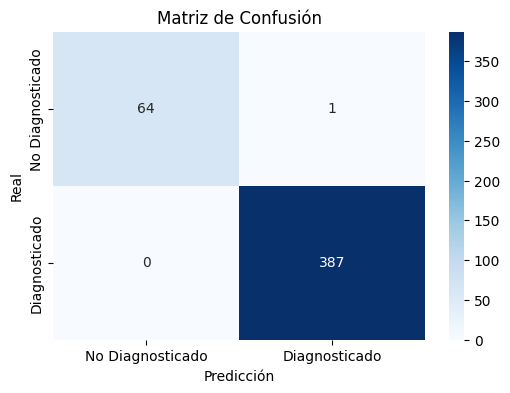

In [48]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión como gráfico de calor
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diagnosticado', 'Diagnosticado'], yticklabels=['No Diagnosticado', 'Diagnosticado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

---

### Predecir la Probabilidad de un Trastorno del Sueño

In [49]:
# 1. Preparar las variables
X = df.drop(columns=['Sleep_disorder', 'Patient_ID'])  # Eliminar la columna objetivo y cualquier identificador único
y = df['Sleep_disorder']  # La variable objetivo es si tiene trastorno del sueño o no (1 o 0)

# 2. Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Preprocesamiento y escalado
# Vamos a separar las variables numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['int64']).columns

# Preprocesador: Escalado de características numéricas y OneHotEncoding de las categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Escalar las variables numéricas
        ('cat', OneHotEncoder(), categorical_features)  # Codificar las variables categóricas
    ])

# 4. Entrenamiento del modelo usando un Pipeline
# Aquí usamos un Random Forest para la clasificación
model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Aplica la transformación a las características
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))  # Ajustamos los pesos de clase
])

# 5. Entrenar el modelo
model.fit(X_train, y_train)

# 6. Evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy en el conjunto de prueba: {accuracy}")
print(f"Classification Report:\n{report}")

# 7. Predicción de probabilidad para el trastorno del sueño
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase '1' (trastorno del sueño)
print(f"Probabilidades predichas para el trastorno del sueño en el conjunto de prueba:\n{y_proba[:10]}")  # Mostrar las primeras 10 probabilidades

Accuracy en el conjunto de prueba: 0.8628318584070797
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       152
           1       0.72      0.84      0.78        37
           2       0.81      0.74      0.77        23
           3       0.90      0.93      0.92        99
           4       0.74      0.72      0.73        43
           5       0.90      0.85      0.87        98

    accuracy                           0.86       452
   macro avg       0.83      0.83      0.83       452
weighted avg       0.86      0.86      0.86       452

Probabilidades predichas para el trastorno del sueño en el conjunto de prueba:
[0.14       0.         0.01       0.00427481 0.         0.
 0.01       0.         0.00723247 0.44147555]
